In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import pytensor.tensor as pt
import numpyro

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#graphvizを使うためPATHを設定
import os
# Replace 'path_to_graphviz_bin' with the actual path to your Graphviz 'bin' directory.
# 仮想環境名が通常のPymc環境(/opt/conda/envs/pymc-dev/bin/)と違うため注意
graphviz_bin_path = '/opt/conda/envs/pymc-test/bin/'
# Append the Graphviz 'bin' directory to the PATH.
os.environ["PATH"] += os.pathsep + graphviz_bin_path

(array([48., 52., 44., 27.,  9.,  8.,  6.,  3.,  1.,  2.]),
 array([1.06711209e-03, 3.33006855e-01, 6.64946597e-01, 9.96886340e-01,
        1.32882608e+00, 1.66076582e+00, 1.99270557e+00, 2.32464531e+00,
        2.65658505e+00, 2.98852479e+00, 3.32046454e+00]),
 <BarContainer object of 10 artists>)

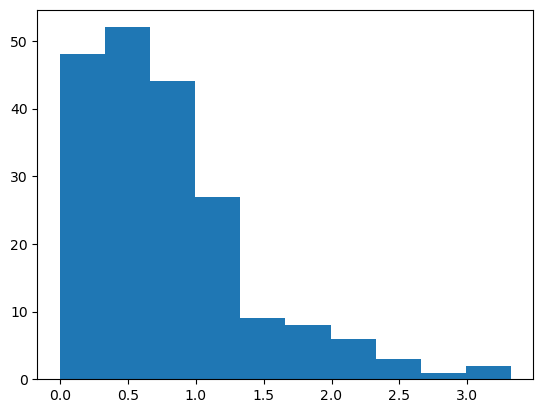

In [3]:
#標準偏差:1の半正規分布をサンプリング
temp1 = pm.HalfNormal.dist(sigma=1,shape=(200,))
a1_true = pm.draw(temp1)

plt.hist(a1_true)

In [4]:
a1_true.shape

(200,)

(array([ 1.,  7., 20., 24., 49., 46., 28., 14.,  7.,  4.]),
 array([-2.8307656 , -2.26021848, -1.68967136, -1.11912424, -0.54857711,
         0.02197001,  0.59251713,  1.16306426,  1.73361138,  2.3041585 ,
         2.87470562]),
 <BarContainer object of 10 artists>)

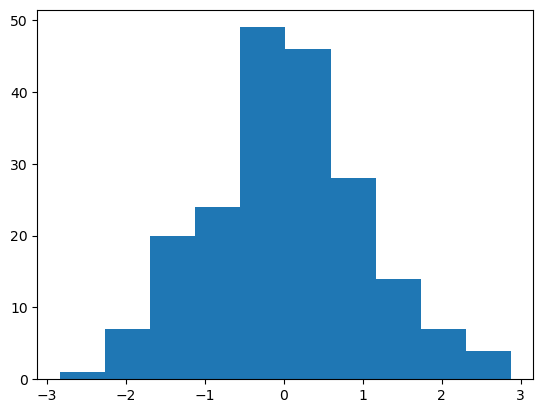

In [5]:
#標準偏差:1の正規分布をサンプリング
temp2 = pm.Normal.dist(sigma=1,shape=(200,))
a2_true = pm.draw(temp2)

plt.hist(a2_true)

In [6]:
pd.DataFrame({'a1_true':a1_true,'a2_true':a2_true})

,a1_true,a2_true
0,1.885078,2.389592
1,0.528028,-0.485020
2,1.790835,0.610305
3,0.383734,-1.609484
4,1.432716,-1.367358
...,...,...
195,0.687220,0.194004
196,0.140179,-0.100480
197,0.236119,-0.452414
198,0.630156,-0.612642


## 考え方  
a1_trueは半正規分布からサンプルした200の値　a2_trueは正規分布からサンプルした200の値  
↑が推定したい事前分布  
次に2×200行の一様分布からサンプルした特徴量を生成する(いわゆる観測できる値)

In [7]:
# 下限0,上限1の一様分布から200個サンプル
temp3 = pm.Uniform.dist(lower=0, upper=1,shape=(200,))
temp4 = pm.Uniform.dist(lower=0, upper=1,shape=(200,))
x1 = pm.draw(temp3)
x2 = pm.draw(temp4)

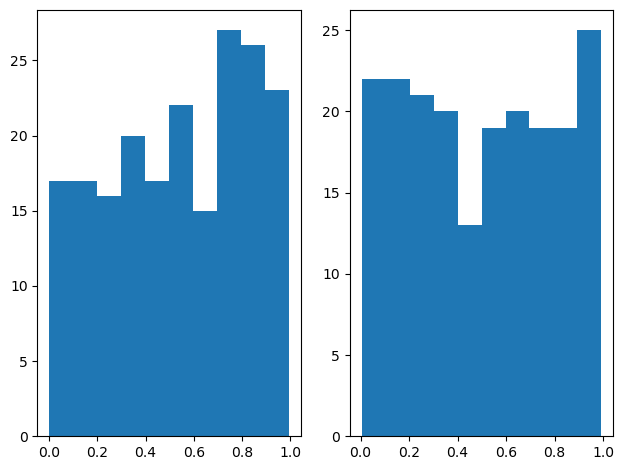

In [8]:
# 作成したx1,x2を可視化
fig ,ax = plt.subplots(1,2)
ax[0].hist(x1)
ax[1].hist(x2)
fig.tight_layout()

In [9]:
# 真の値を利用した目的変数を作成　変数複数
y = x1 *a1_true + x2 *a2_true

In [10]:
y

array([ 1.98455995,  0.27875701,  1.71499316, -1.26044118,  0.25757752,
        0.97200882,  0.47379743,  0.31854876,  0.25086192, -0.00738271,
        1.05189251,  0.63579171, -0.14139708, -0.62757132,  1.18714321,
       -0.15116687,  1.41153694,  0.68234376,  0.06914277,  2.00043894,
       -0.4465414 ,  0.08833915,  0.21350118,  2.30081194, -0.02380603,
        1.70538724,  0.61142839,  0.23545581, -0.26635797, -0.53130386,
        0.05468217,  0.58397988,  0.54994628, -0.10742821,  0.40610353,
       -0.20168384,  0.18317251,  2.06514736,  0.92290603,  1.03382518,
        0.29646713,  0.36430221,  0.62793919,  0.19260317, -0.77156619,
        0.37537265, -0.16060476,  0.5230152 , -0.53853191,  1.56885173,
        0.26763771,  1.10228476,  0.11070397,  0.55633718,  0.62985012,
        0.0342682 , -0.28149143,  0.75640225,  0.71698982, -0.20693282,
        0.85867222,  0.3093963 ,  0.92593767,  0.25281066,  0.82237118,
       -0.06543597,  0.83386335,  0.46269925,  0.27126153,  1.19

(array([ 6.,  8., 20., 55., 48., 26., 23.,  7.,  3.,  4.]),
 array([-1.26044118, -0.88190645, -0.50337172, -0.12483699,  0.25369773,
         0.63223246,  1.01076719,  1.38930192,  1.76783664,  2.14637137,
         2.5249061 ]),
 <BarContainer object of 10 artists>)

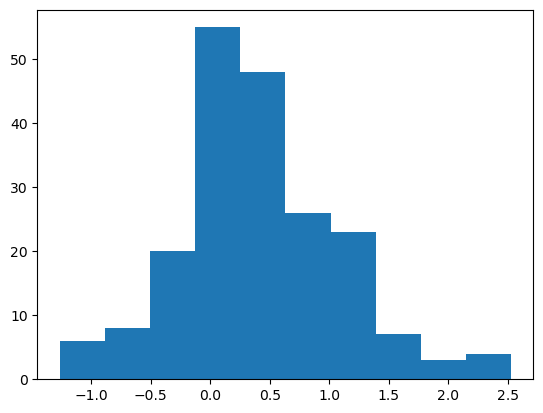

In [11]:
plt.hist(y)

In [12]:
df1 = pd.DataFrame({'x1':x1,'x2':x2, 'y':y})

In [13]:
# 観測できているデータを確認
df1

,x1,x2,y
0,0.764502,0.227408,1.984560
1,0.771525,0.265205,0.278757
2,0.816363,0.414583,1.714993
3,0.447426,0.889809,-1.260441
4,0.967828,0.825713,0.257578
...,...,...,...
195,0.810422,0.771383,0.706589
196,0.572886,0.545369,0.025508
197,0.777445,0.929568,-0.236979
198,0.825403,0.866709,-0.010849


## モデル1を作成  
x1には半正規分布の事前分布を設定  
x２には正規分布の事前分布を設定  
y(尤度)はStudentT分布にする

In [14]:
df_x1=df1['x1']
df_x2=df1['x2']
df_y =df1['y']

In [24]:
model1 = pm.Model()

In [25]:
with model1:
    #観測データを定義
    model1.add_coord('data',df_x1.index, mutable=True)
    model1.add_coord('var',df1.columns, mutable=True)
    x1_data= pm.Data("x1_data", df_x1, dims=('data'), mutable=True)
    x2_data= pm.Data("x2_data", df_x2, dims=('data'), mutable=True)
    y_data = pm.Data("y_data", df_y, dims=('data'), mutable=True)

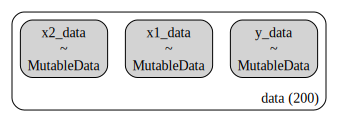

In [26]:
pm.model_to_graphviz(model1)

In [27]:
with model1:
    #事前分布を定義
    
    #切片を標準偏差100の正規分布で定義
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    #x1の傾きを半正規分布で定義
    a1 = pm.HalfNormal("a1", sigma=100)
    #x2の傾きを正規分布で定義
    a2= pm.Normal("a2",mu=0, sigma=100)
    
    #誤差を半正規分布で定義
    epsilon = pm.HalfNormal("epsilon", sigma=100)

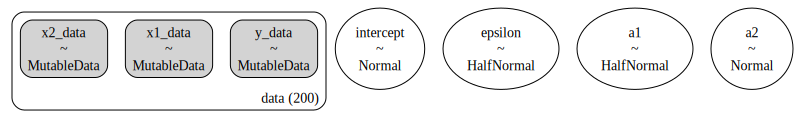

In [28]:
pm.model_to_graphviz(model1)

In [29]:
with model1:
    #観測データ(正規分布を仮定)の平均を計算　重回帰の計算結果が平均となる
    mu = pm.Deterministic("mu", intercept + pt.dot(x1_data, a1) + pt.dot(x2_data,a2), dims=('data',))
    #StudentT分布のパラメータの事前分布を定義
    nu = pm.Gamma("nu",alpha=2,beta=0.1,dims=('data',))
    
    #観測データ(尤度)(正規分布を仮定)を定義
    obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=epsilon, observed=y_data, dims=('data',)) 

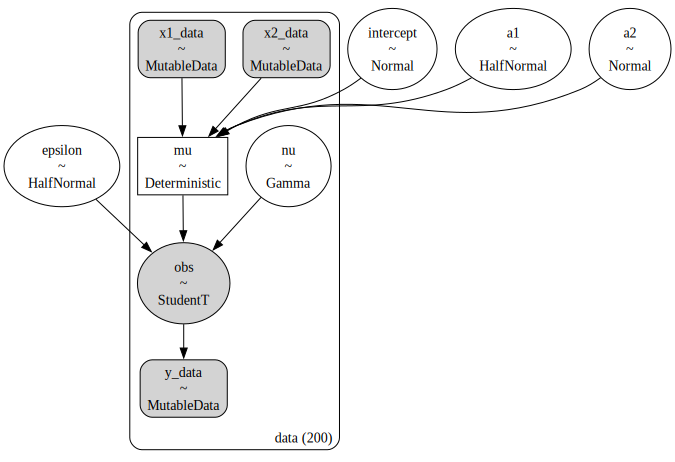

In [30]:
pm.model_to_graphviz(model1)

### 事前分布の妥当性を確認するために事前分布を用いてサンプリング

In [31]:
with model1:
    idata = pm.sample_prior_predictive(samples=200, random_seed=42)

Sampling: [a1, a2, epsilon, intercept, nu, obs]


(0.0, 1.0)

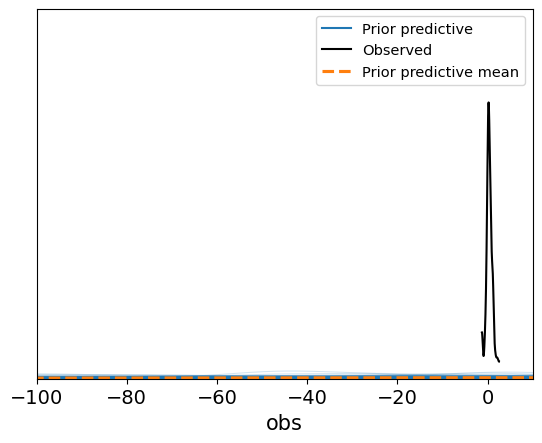

In [98]:
az.plot_ppc(idata, num_pp_samples=200, group="prior")
plt.xlim(-100, 10)
plt.ylim(0,1)

#### モデル2を作成  
x1には半正規分布の事前分布を設定  
x２には正規分布の事前分布を設定  
y(尤度)は正規分布にする

In [64]:
model2 = pm.Model()

In [65]:
with model2:
    #観測データを定義
    model1.add_coord('data',df_x1.index, mutable=True)
    model1.add_coord('var',df1.columns, mutable=True)
    x1_data= pm.Data("x1_data", df_x1, dims=('data'), mutable=True)
    x2_data= pm.Data("x2_data", df_x2, dims=('data'), mutable=True)
    y_data = pm.Data("y_data", df_y, dims=('data'), mutable=True)

In [66]:
with model2:
    #事前分布を定義
    
    #切片を標準偏差100の正規分布で定義
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    #x1の傾きを半正規分布で定義
    a1 = pm.HalfNormal("a1", sigma=100)
    #x2の傾きを正規分布で定義
    a2= pm.Normal("a2",mu=0, sigma=100)
    
    #誤差を半正規分布で定義
    epsilon = pm.HalfNormal("epsilon", sigma=100)

In [67]:
with model2:
    #観測データ(正規分布を仮定)の平均を計算　重回帰の計算結果が平均となる
    mu = pm.Deterministic("mu", intercept + pt.dot(x1_data, a1) + pt.dot(x2_data,a2), dims=('data',))
    
    #観測データ(尤度)(正規分布を仮定)を定義
    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=y_data, dims=('data',)) 

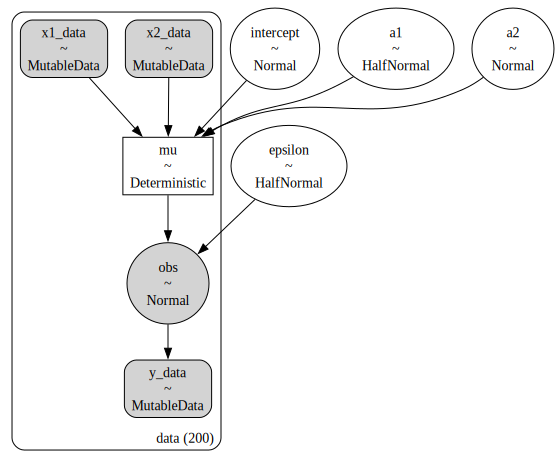

In [68]:
# モデルの構成は変わらない
pm.model_to_graphviz(model2)

#### 再度事前分布からサンプリング

In [69]:
with model2:
    idata = pm.sample_prior_predictive(samples=200, random_seed=42)

Sampling: [a1, a2, epsilon, intercept, obs]


(0.0, 1.0)

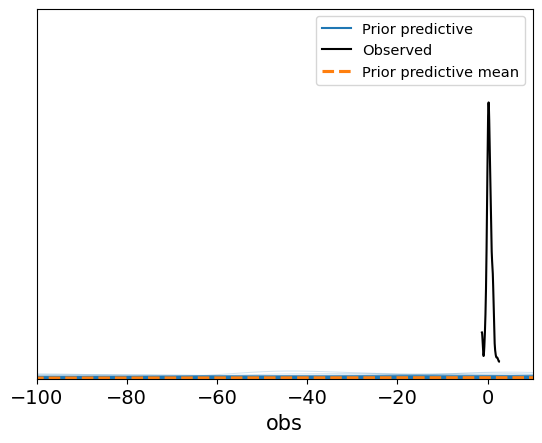

In [97]:
az.plot_ppc(idata, num_pp_samples=200, group="prior")
plt.xlim(-100, 10)
plt.ylim(0,1)

#### MCMC実行

In [40]:
with model1:
    idata1 = pm.sample(nuts_sampler="blackjax",random_seed=42)

Compiling...
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/pymc/sampling/jax.py:459: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
Compilation time = 0:00:01.378262
Sampling...
Sampling time = 0:00:06.209216
Transforming variables...
Transformation time = 0:00:00.155323


In [41]:
summary1 = az.summary(idata1,var_names=['a1','a2','epsilon'])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,0.608,0.153,0.322,0.891,0.003,0.002,3263.0,1878.0,1.0
a2,-0.111,0.149,-0.383,0.182,0.002,0.002,4217.0,3082.0,1.0
epsilon,0.583,0.035,0.517,0.649,0.000,0.000,5203.0,3264.0,1.0


In [71]:
# MCMC実行　サンプラー:blackjax
with model2:
    idata2 = pm.sample(nuts_sampler="blackjax",random_seed=42)

Compiling...
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/pymc/sampling/jax.py:459: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
Compilation time = 0:00:00.646776
Sampling...
Sampling time = 0:00:03.364050
Transforming variables...
Transformation time = 0:00:00.083511


In [72]:
#R_hat 1.0のため収束出来てそう
summary2 = az.summary(idata2,var_names=['a1','a2','epsilon'])
display(summary2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,0.609,0.164,0.286,0.906,0.004,0.003,2044.0,1467.0,1.0
a2,-0.128,0.156,-0.429,0.159,0.003,0.003,2326.0,2180.0,1.0
epsilon,0.656,0.033,0.597,0.721,0.001,0.000,2771.0,2432.0,1.0


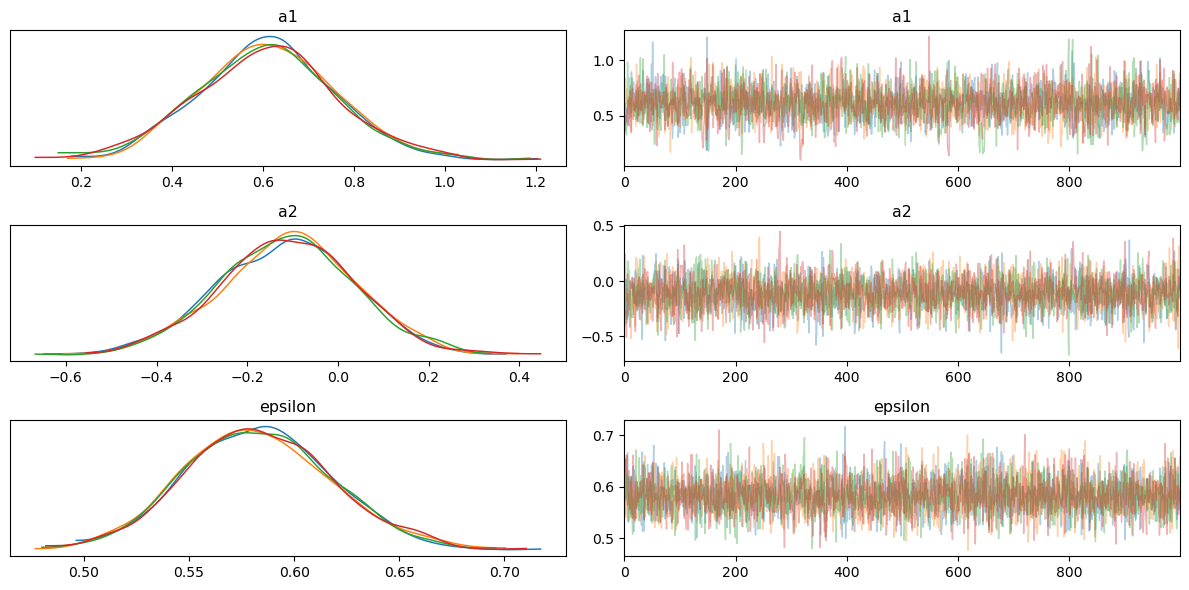

In [44]:
#model1のトレース結果
az.plot_trace(idata1, compact=False, var_names=['a1','a2','epsilon'])
plt.tight_layout()

array([<Axes: title={'center': 'a1'}>, <Axes: title={'center': 'a2'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

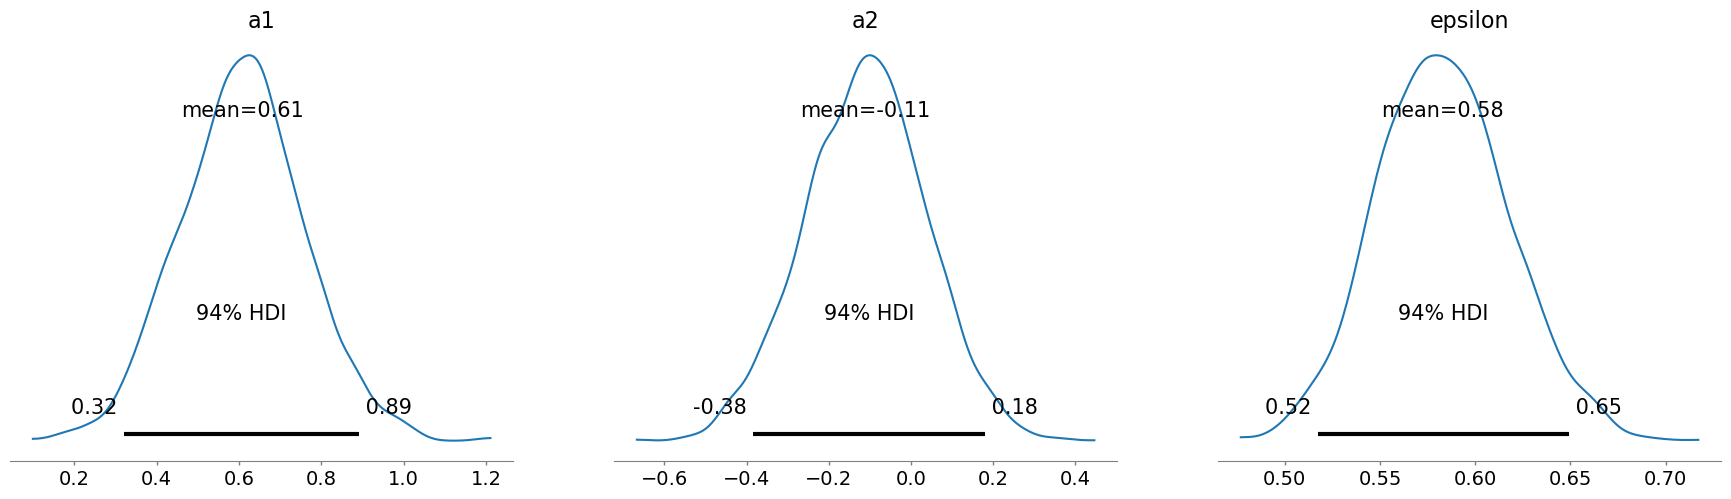

In [45]:
#model1のサンプラーのトレース結果
az.plot_posterior(idata1, var_names=['a1','a2','epsilon'])

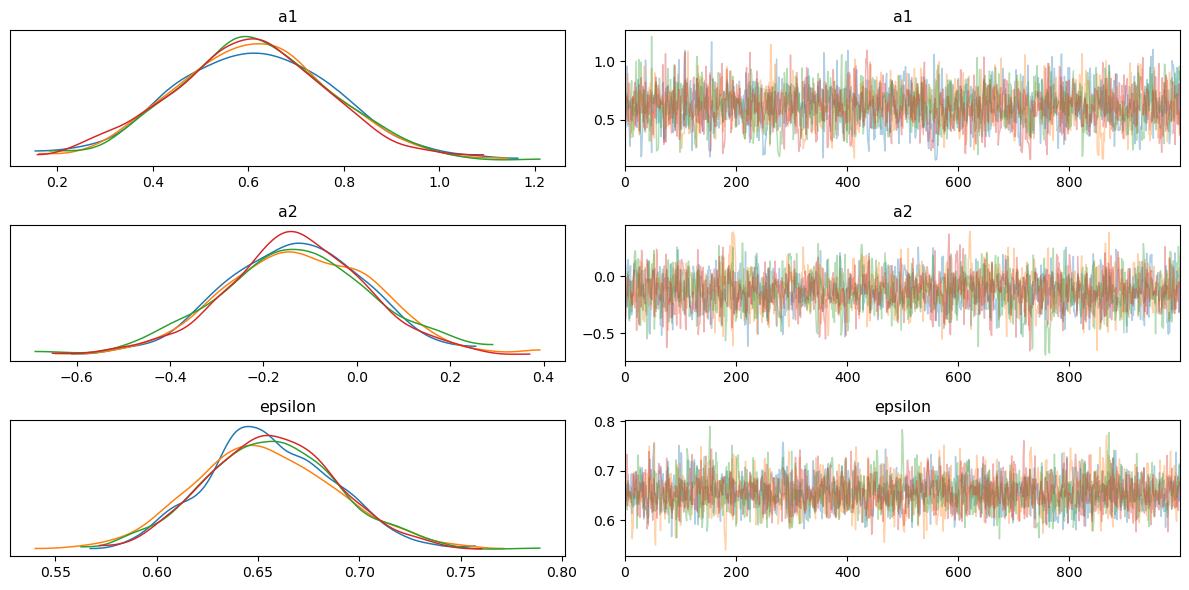

In [73]:
#model2トレース結果
az.plot_trace(idata2, compact=False, var_names=['a1','a2','epsilon'])
plt.tight_layout()

array([<Axes: title={'center': 'a1'}>, <Axes: title={'center': 'a2'}>,
       <Axes: title={'center': 'epsilon'}>], dtype=object)

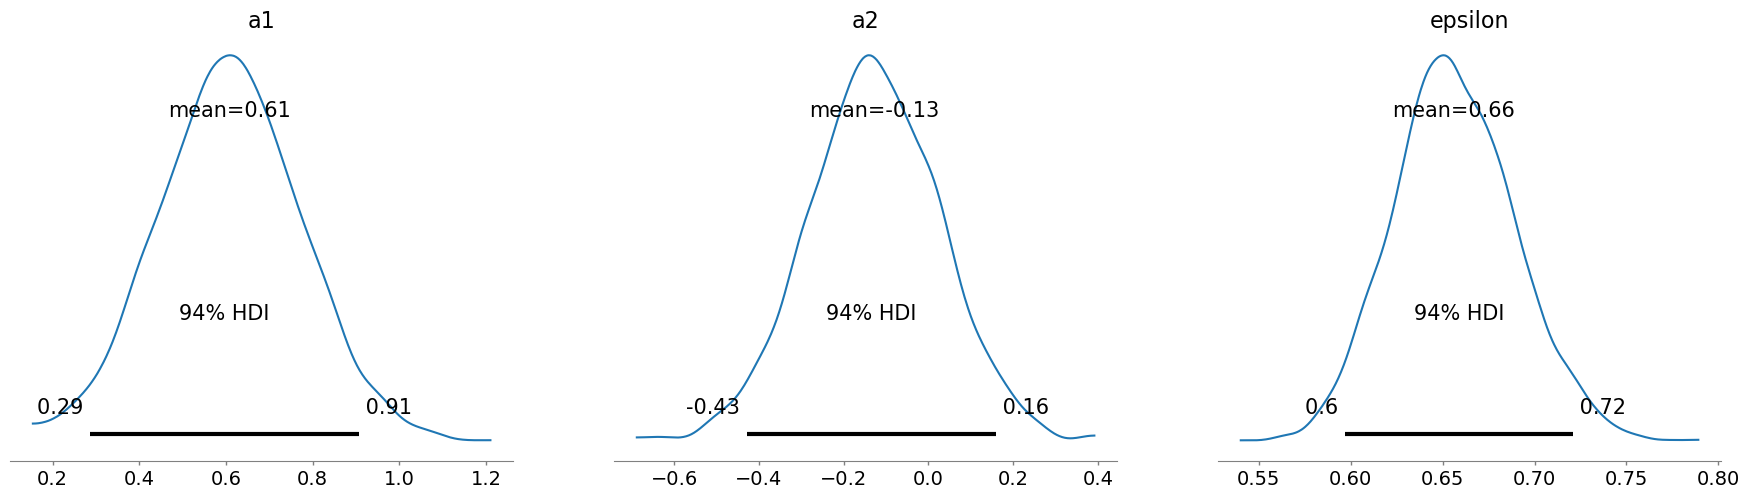

In [74]:
#model2のトレース結果
az.plot_posterior(idata2, var_names=['a1','a2','epsilon'])

##### Energyプロットを確認  
理想的なプロットとしてはMarginal EnergyとEnergy Transitionの分布が一致しているこ  
一致していればHMCやNUTSは目的としている分布をよくサンプリングできていることを意味する  
Energy Transition分布の方がMarginal Energyの分布より狭い場合、HMCやNUTSは目的としている領域の一部しかサンプリングできていないことを意味する

<Axes: >

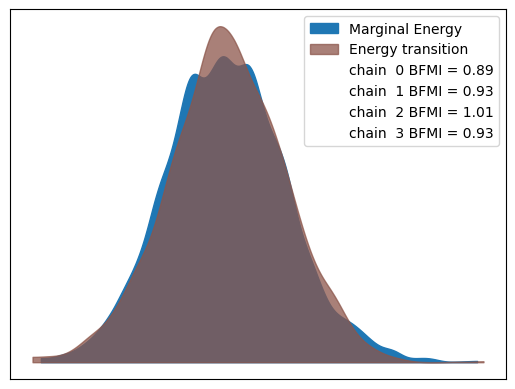

In [48]:
az.plot_energy(idata1)

<Axes: >

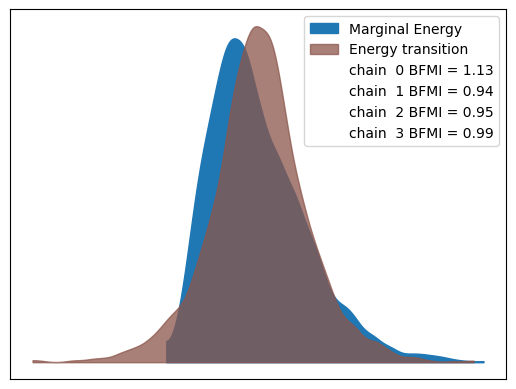

In [75]:
az.plot_energy(idata2)

In [90]:
#事後分布のチェック
with model1:
    idata1.extend(pm.sample_posterior_predictive(idata1))

Sampling: [obs]


## MCMCの結果考察  
R_hatが1.0、グラフも定常状態になっているため収束出来ていると判断  
Marginal EnergyとEnergy Transitionの分布もどちらのModelもある程度一致しているためサンプリングもある程度上手くできている

## 真の値とMCMCの結果の比較

In [76]:
a1_true.mean()

0.7904759310997804

In [77]:
#model1のa1の平均値
idata1['posterior']['a1'].values.mean()

0.6079411403530165

In [78]:
#model2のa1の平均値
idata2['posterior']['a1'].values.mean()

0.6086062802432489

In [79]:
a2_true.mean()

0.039680035220801525

In [80]:
#model1のa2の平均値
idata1['posterior']['a2'].values.mean()

-0.11127307390071768

In [81]:
#model2のa2の平均値
idata2['posterior']['a2'].values.mean()

-0.12817465551760807

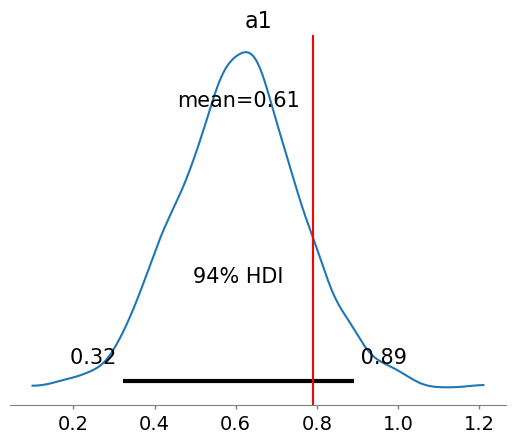

In [82]:
## model1のa1結果確認
az.plot_posterior(idata1, var_names=['a1'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a1_true.mean(),color='red')

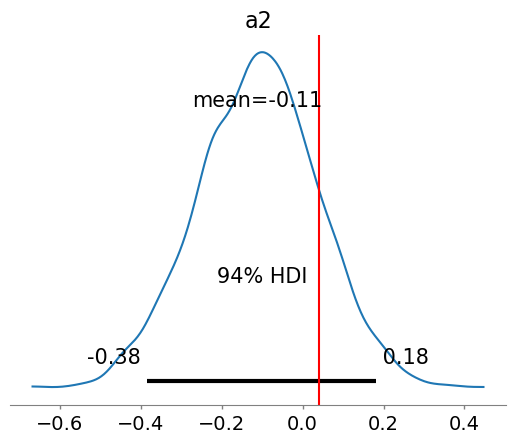

In [83]:
## model1のa2結果確認
az.plot_posterior(idata1, var_names=['a2'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a2_true.mean(),color='red')

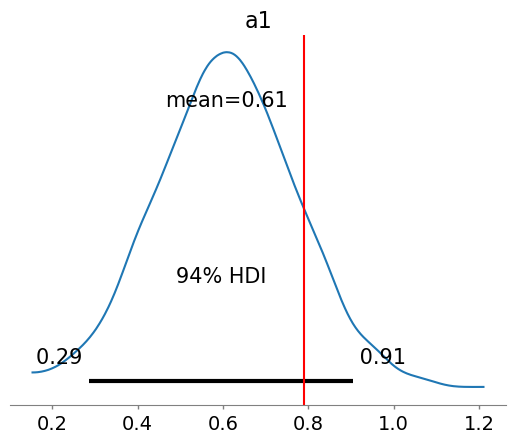

In [84]:
## model2のa1結果確認
az.plot_posterior(idata2, var_names=['a1'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a1_true.mean(),color='red')

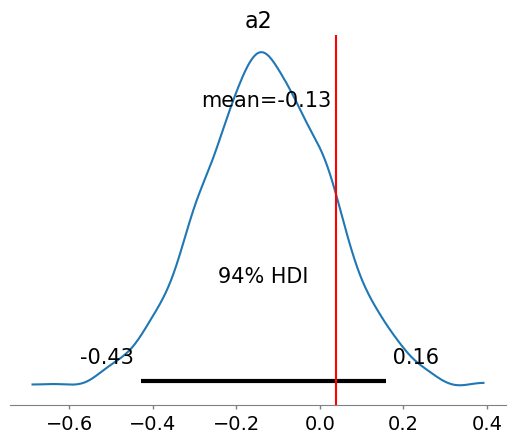

In [85]:
## model2のa2結果確認
az.plot_posterior(idata2, var_names=['a2'])
#a1_trueの真の値の平均値の線を引く
plt.axvline(x=a2_true.mean(),color='red')

### Model比較

In [60]:
with model1:
    pm.compute_log_likelihood(idata1)

In [86]:
with model2:
    pm.compute_log_likelihood(idata2)

In [87]:
df_comp_loo = az.compare({"model1": idata1, "model2": idata2})
df_comp_loo

/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1,0,-198.762577,6.794486,0.000000,1.0,12.677415,0.000000,True,log
model2,1,-201.189478,4.611910,2.426901,0.0,12.197629,1.658457,False,log


/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

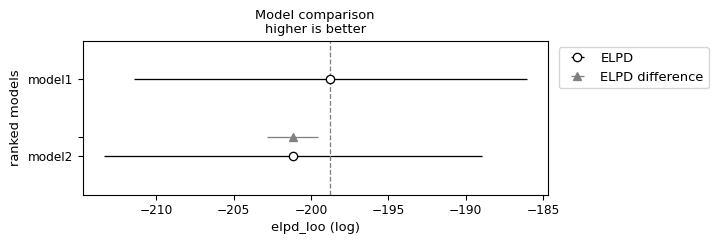

In [88]:
az.plot_compare(df_comp_loo, insample_dev=False)

## モデル比較の解釈  
尤度がStudentT分布のほうが若干良い